<a href="https://colab.research.google.com/github/Aspire-Mayank/EVA/blob/master/Session25/Session_25_GAN_DCGAN_Conv2DTranspose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Set tensorflow version to 1.x
%tensorflow_version 1.x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#@title Import Libs
import numpy as np
import time, math
# from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

%matplotlib inline

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.15.0


In [4]:
!wget -O cars.zip https://github.com/yoyoasa/visutils/blob/master/photos/cars.zip?raw=true

--2019-12-11 08:36:33--  https://github.com/yoyoasa/visutils/blob/master/photos/cars.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yoyoasa/visutils/raw/master/photos/cars.zip [following]
--2019-12-11 08:36:33--  https://github.com/yoyoasa/visutils/raw/master/photos/cars.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yoyoasa/visutils/master/photos/cars.zip [following]
--2019-12-11 08:36:34--  https://raw.githubusercontent.com/yoyoasa/visutils/master/photos/cars.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [0]:
!rm -rf cars

In [7]:
!unzip cars.zip -d cars

Archive:  cars.zip
replace cars/cars/cars (182).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cars/cars/cars (182).jpg  
replace cars/cars/cars (478).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: cars/cars/cars (478).jpg  
  inflating: cars/cars/cars (881).jpg  
  inflating: cars/cars/cars (497).jpg  
  inflating: cars/cars/cars (244).jpg  
  inflating: cars/cars/cars (614).jpg  
  inflating: cars/cars/cars (301).jpg  
  inflating: cars/cars/cars (751).jpg  
  inflating: cars/cars/cars (585).jpg  
  inflating: cars/cars/cars (1004).jpg  
  inflating: cars/cars/cars (839).jpg  
  inflating: cars/cars/cars (993).jpg  
  inflating: cars/cars/cars (643).jpg  
  inflating: cars/cars/cars (213).jpg  
  inflating: cars/cars/cars (51).jpg  
  inflating: cars/cars/cars (706).jpg  
  inflating: cars/cars/cars (356).jpg  
  inflating: cars/cars/cars (439).jpg  
  inflating: cars/cars/cars (593).jpg  
  inflating: cars/cars/cars (985).jpg  
  inflating: cars/cars/cars (205)

In [8]:
# /content/cars/cars

from PIL import Image 
import glob

path = '/content/cars/cars'
files = [f for f in glob.glob(path + "**/*.jpg", recursive=True)]
images = []

for f in files:
    images.append(np.array(Image.open(f)))

images = np.array(images)
print(images.shape)

def load_data():
    return images

(1005, 100, 100, 3)


In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 100
        self.img_cols = 100
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 256

        self.r = 5
        self.c = 5
        self.noise = np.random.normal(0, 1, (self.r * self.c, self.latent_dim))

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_noise_vector(self):
        return self.noise

    def build_generator(self):

        model = Sequential()

        model.add(Dense(self.latent_dim * 25 * 25, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((25, 25, self.latent_dim)))
        model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = self.r, self.c
        gen_imgs = self.generator.predict(self.noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(10,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


In [0]:
!mkdir /content/images

In [11]:
dcgan = DCGAN()
dcgan.train(epochs=20000, batch_size=64, save_interval=50)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 26, 26, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________

In [0]:
!cp -r /content/images/* /content/drive/My\ Drive/SOAI/EVA/Session25_GAN/

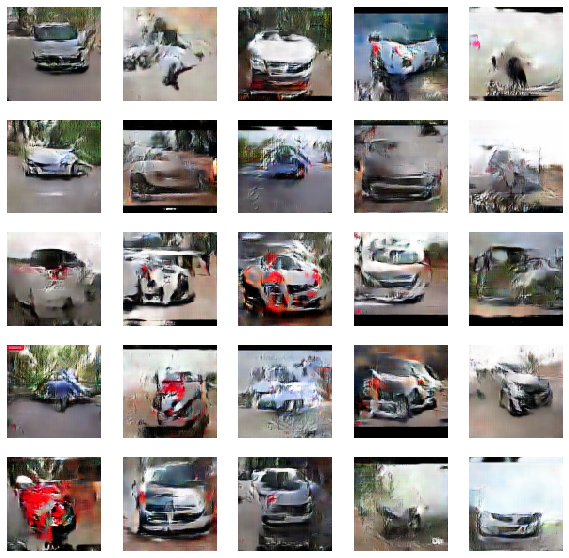

In [17]:
%matplotlib inline
r, c = dcgan.r, dcgan.c
gen_imgs = dcgan.generator.predict(dcgan.get_noise_vector())

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i,j].axis('off')
        cnt += 1
fig.show()

In [0]:
from PIL import Image 
import os

path = '/content/images'
files = [os.path.join(path, '{}.png'.format(f)) for f in range(0, 19951, 50)]

images = []

for f in files:
    try:
        images.append(Image.open(f))
    except:
        continue

images[0].save('gan.gif', save_all=True, append_images=images[1:], optimize=False, duration=1, loop=0)

In [0]:
dcgan.train(epochs=20000, batch_size=64, save_interval=50)

In [0]:
!cp -r /content/images/* /content/drive/My\ Drive/SOAI/EVA/Session25_GAN/

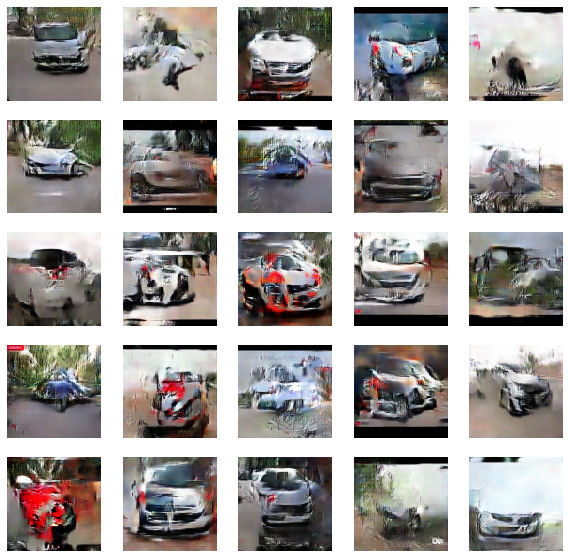

In [21]:
%matplotlib inline
r, c = dcgan.r, dcgan.c
gen_imgs = dcgan.generator.predict(dcgan.get_noise_vector())

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i,j].axis('off')
        cnt += 1
fig.show()